In [1]:
import torch
from mmrotate._C import box_iou_rotated
from mmrotate._C import nms_rotated

In [2]:
mvtec = torch.load("../datasets/mvtec.pth")

In [3]:
from ops.boxes import obb2poly, hbb2obb

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
from shapely import Polygon

In [5]:
def iou(polygon1, polygon2):
    intersect = polygon1.intersection(polygon2).area
    union = polygon1.union(polygon2).area
    iou = intersect / union
    return iou

def diff_iou(data, data_idx = 0):
    oboxes = data['train'][data_idx]['oboxes']
    polys = data['train'][data_idx]['polygons']
    polys = polys.numpy().reshape(-1, 4, 2)
    
    hboxes = data['train'][data_idx]['bboxes']
    
    converted_oboxes = hbb2obb(hboxes)
    converted_oboxes_poly = obb2poly(converted_oboxes)
    converted_oboxes_poly = converted_oboxes_poly.numpy().reshape(-1, 4, 2)
    
    n = len(polys)

    poly_ious = torch.empty((n, n), dtype=torch.float32)
    for i in range(n):
        for j in range(n):
            poly_ious[i, j] = iou(Polygon(polys[i]), Polygon(converted_oboxes_poly[j]))
    
    # converted_oboxes[:, -1] = -converted_oboxes[:, -1]
    # oboxes[:, -1] = -oboxes[:, -1]
    # mode_flag = 0: standard IOU (Union is a+b-a&b)
    # mode_flag = 1: IOU (Union is a)
    # in principle, aligned=True is better
    # oboxes = oboxes.cuda()
    # converted_oboxes = converted_oboxes.cuda()
    oboxes_ious = box_iou_rotated(oboxes, oboxes, 0, False)
    print("oboxes_ious", oboxes_ious.shape)
    poly_ious = poly_ious.diag()
    oboxes_ious = oboxes_ious.diag()
    poly_ious = poly_ious
    return torch.abs(poly_ious-oboxes_ious).diag().mean(), torch.isclose(poly_ious, oboxes_ious)
    

In [7]:
avg_l1 = torch.tensor(0.0)
for i in range(len(mvtec)):
    l1, is_close = diff_iou(mvtec, data_idx=i)
    avg_l1 += l1
avg_l1 /= len(mvtec)
print(avg_l1)

oboxes_ious torch.Size([16, 16])
oboxes_ious torch.Size([16, 16])
oboxes_ious torch.Size([16, 16])
oboxes_ious torch.Size([16, 16])
tensor(0.0288)


In [34]:
nms_rotated()

TypeError: nms_rotated(): incompatible function arguments. The following argument types are supported:
    1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: torch.Tensor, arg3: torch.Tensor, arg4: float, arg5: int) -> torch.Tensor

Invoked with: 

In [16]:
data_idx = 0
data = mvtec['train'][data_idx]
hboxes = data['bboxes']
oboxes_from_hboxes = hbb2obb(hboxes)
poly_from_oboxes = obb2poly(oboxes_from_hboxes)
image_path = data['image_path']
from PIL import Image, ImageDraw
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
for hbox in hboxes:
    draw.rectangle(hbox.tolist(), outline='red', width=5)
    
for poly_obox in poly_from_oboxes:
    draw.polygon(poly_obox.tolist(), outline='blue', width=3)



In [22]:
nms_rotated(oboxes_from_hboxes, torch.rand(size=[oboxes_from_hboxes.shape[0],]), torch.randint(0, 10, size=[oboxes_from_hboxes.shape[0],]).float())

TypeError: nms_rotated(): incompatible function arguments. The following argument types are supported:
    1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: float) -> torch.Tensor

Invoked with: tensor([[ 875.5000,  184.0000,   62.0000,   55.0000,    1.5708],
        [1282.0000,  448.5000,  599.0000,  250.0000,    1.5708],
        [1249.0000,  888.0000,  712.0000,  806.0000,    1.5708],
        [ 471.5000,  432.5000,  839.0000,  675.0000,    1.5708],
        [ 941.0000, 1206.0000,   60.0000,   62.0000,    1.5708],
        [1343.0000,  900.5000,  271.0000,  252.0000,    1.5708],
        [ 930.0000, 1041.0000,  274.0000,  252.0000,    1.5708],
        [ 504.5000,  601.5000,  323.0000,  219.0000,    1.5708],
        [1041.0000, 1154.5000,  309.0000,  264.0000,    1.5708],
        [ 860.5000, 1251.5000,  291.0000,   99.0000,    1.5708],
        [ 812.0000, 1145.5000,  249.0000,   90.0000,    1.5708],
        [1029.5000,  306.5000,  243.0000,  311.0000,    1.5708],
        [ 816.0000,  285.0000,  238.0000,  126.0000,    1.5708],
        [ 953.0000,  448.5000,  283.0000,  724.0000,    1.5708],
        [ 901.0000,  716.5000,  429.0000,  550.0000,    1.5708],
        [ 833.5000,  763.5000,  495.0000,  643.0000,    1.5708]]), tensor([0.8890, 0.0011, 0.2416, 0.9981, 0.6903, 0.5479, 0.2210, 0.6394, 0.0247,
        0.0991, 0.1836, 0.1491, 0.3070, 0.5587, 0.6295, 0.2407]), tensor([3., 7., 8., 9., 4., 7., 9., 0., 2., 5., 7., 1., 9., 6., 8., 5.])

In [1]:
import sys
sys.path.append("..")

In [1]:
from torchvision.ops import MultiScaleRoIAlign
from ops.poolers import MultiScaleRotatedRoIAlign
from torchvision.transforms import Resize
import torch

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
rroi_align = MultiScaleRotatedRoIAlign(['feat1', 'feat3'], 3, 2)
roi_align = MultiScaleRoIAlign(['feat1', 'feat3'], 3, 2)
i = {}
i['feat1'] = torch.rand(1, 5, 64, 64)
i['feat3'] = torch.rand(1, 5, 16, 16)
num_rois = 1
# create some random rotated bounding boxes
boxes = torch.rand(num_rois, 4) * 256
boxes[:, 2:] += boxes[:, :2]

angles = torch.ones(num_rois, 1) * torch.pi / 2 
cx = (boxes[:, 0:1] + boxes[:, 2:3]) / 2
cy = (boxes[:, 1:2] + boxes[:, 3:4]) / 2
w = boxes[:, 2:3] - boxes[:, 0:1]
h = boxes[:, 3:4] - boxes[:, 1:2]
boxes_with_angles = torch.cat((cx, cy, w, h, angles), dim=1)
# original image size, before computing the feature maps
image_sizes = [(512, 512)]
rroi = rroi_align(i, [boxes_with_angles], image_sizes)
roi = roi_align(i, [boxes], image_sizes)

In [3]:
boxes

tensor([[251.3783, 196.3967, 492.6345, 392.3176]])

In [4]:
from ops.boxes import hbb2obb

In [5]:
hbb2obb(boxes)

tensor([[372.0064, 294.3571, 241.2562, 195.9209,   0.0000]])

In [6]:
boxes_with_angles

tensor([[372.0064, 294.3571, 241.2562, 195.9209,   1.5708]])

In [75]:
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from torchvision.transforms import PILToTensor
from PIL import Image, ImageDraw
mvtec = torch.load("../datasets/mvtec.pth")
item = mvtec['test'][1]
image_path = item['image_path']
bboxes = item['bboxes']
# oboxes = hbb2obb(bboxes)
oboxes = item['oboxes']

image = Image.open(image_path).convert('RGB')
image_tensor = PILToTensor()(image)
image_tensor = image_tensor.unsqueeze(0)

In [76]:
# oboxes[:, -1] = -oboxes[:, -1]
# oboxes[:, (2, 3)] = oboxes[:, (3, 2)]

In [77]:
i = {}
i['feat1'] = image_tensor / 255.0

In [78]:
image_sizes = [(1440, 1920)]
rroi_align = MultiScaleRotatedRoIAlign(['feat1'], 120, 0)
roi_align = MultiScaleRoIAlign(['feat1'], 120, 0)

rroi = rroi_align(i, [oboxes], image_sizes)
roi = roi_align(i, [bboxes], image_sizes)

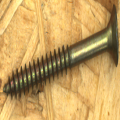

In [79]:
hor = []
for r in roi:
    r=r.squeeze(0)
    imr = to_pil_image(r)
    hor.append(imr)
    
imr

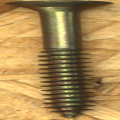

In [80]:
rot = []
for r in rroi:
    r=r.squeeze(0)
    imr = to_pil_image(r)
    rot.append(imr)
imr

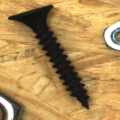

In [81]:
hor[6]

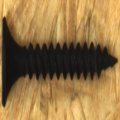

In [82]:
rot[6]

In [83]:
from IPython.display import display

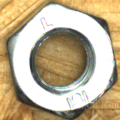

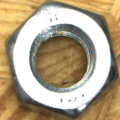

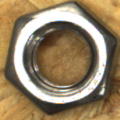

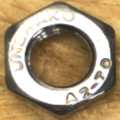

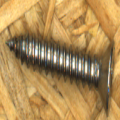

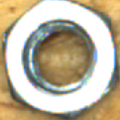

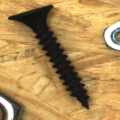

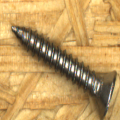

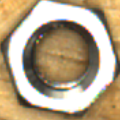

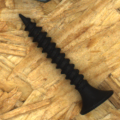

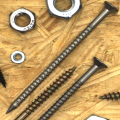

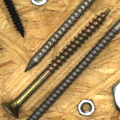

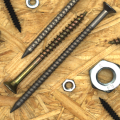

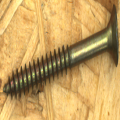

In [85]:
for h in hor:
    display(h)

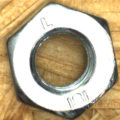

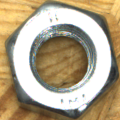

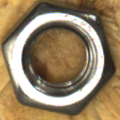

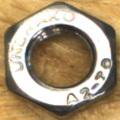

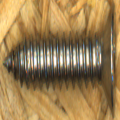

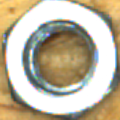

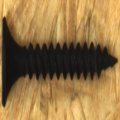

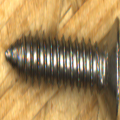

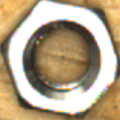

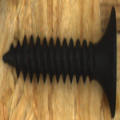

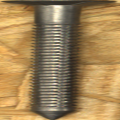

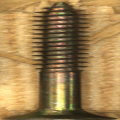

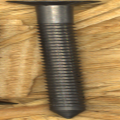

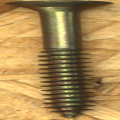

In [84]:
for r in rot:
    display(r)